# Descarga y preparación del entorno

## Instalación de dependencias

In [ ]:
! pip install -r requirements.txt   

## Descomprimir datos
En el repositorio se incluye un archivo comprimido con los datasets en formato `.csv` de los créditos presupuestarios utilizados en el trabajo.

Estos fueron descargados el 5/10/2024 de la página de [presupuesto abierto](https://www.presupuestoabierto.gob.ar/sici/datos-abiertos) del gobierno nacional argentino. Los archivos utilizados se encuentran en la página como "Presupuesto de gastos y su ejecución detallada - agrupación anual".

También se incluye un script de python para descargar todos los datasets de este tipo disponibles al momento (desde 1995 hasta 2024). Se puede encontrar en `utils/descarga-presupuestos.py`.

In [ ]:
import zipfile
import os

# Cambiar al directorio "credito-anual"
os.chdir('data/presupuesto')

# Descomprimir el archivo "credito-anual.zip"
with zipfile.ZipFile('credito-anual.zip', 'r') as zip_ref:
    zip_ref.extractall()

os.chdir('../../')

print('Descomprimido credito-anual.zip')

# Manejo de los datos con Pandas

## Carga de .csv a DataFrames de Pandas

In [24]:
import pandas as pd
DFs = {}
for año in range(2012, 2020):
    df = pd.read_csv(f'data/presupuesto/credito-anual-{año}.csv', decimal=',')
    df.nombre = f'{año}'
    DFs[año] = df

## Deflactación de los valores    

In [25]:
ipim_anual = pd.read_csv('data/ipim/ipim_anual_2012-2019_base_ene_2012.csv')
indice_base = 100

for año in range(2012, 2020):
    indice = ipim_anual[ipim_anual['periodo'] == año].iloc[0]['indice_ipim']

    DFs[año]['credito_pagado'] = (
        DFs[año]['credito_pagado'] / indice) * indice_base

## Funciones para el procesamiento de datos

In [26]:
def generar_dataframe_periodo(DFs, año_comienzo, año_fin):
    df = pd.concat([DFs[año] for año in range(
        año_comienzo, año_fin + 1)], ignore_index=True)
    df.nombre = f'{año_comienzo}-{año_fin}'
    return df


def calcular_total_pagado(df):
    return df['credito_pagado'].sum()


def calcular_total_pagado_por_funcion(df, funcion):
    return df[df['funcion_desc'].str.contains(funcion, na=False)]['credito_pagado'].sum()


def imprimir_resultados(df, total_pagado, total_pagado_trabajo, porcentaje):
    print(f'{df.nombre}:')
    print(f'    Total pagado: {total_pagado:,.2f}')
    print(f'    Total pagado con función \'Trabajo\': {
          total_pagado_trabajo:,.2f}')
    print(f'    Porcentaje pagado con función \'Trabajo\': {porcentaje}%')

## Calculo de inversión con función 'Trabajo' por períodos estudiados

In [40]:
periodos = {}
porcentaje_por_periodo = {}
total_pagado_por_periodo = {}
total_pagado_trabajo_por_periodo = {}
promedio_por_periodo = {}

for periodo in ['2012-2015', '2016-2019', '2012-2019']:
    start_year, end_year = periodo.split('-')
    periodos[periodo] = generar_dataframe_periodo(
        DFs, int(start_year), int(end_year))

    total_pagado_por_periodo[periodo] = calcular_total_pagado(
        periodos[periodo])
    total_pagado_trabajo_por_periodo[periodo] = calcular_total_pagado_por_funcion(
        periodos[periodo], 'Trabajo')
    porcentaje_por_periodo[periodo] = round(
        (total_pagado_trabajo_por_periodo[periodo]/total_pagado_por_periodo[periodo])*100, 2)
    promedio_por_periodo[periodo] = total_pagado_trabajo_por_periodo[periodo] / \
        (int(end_year) - int(start_year) + 1)

    imprimir_resultados(periodos[periodo], total_pagado_por_periodo[periodo],
                        total_pagado_trabajo_por_periodo[periodo], porcentaje_por_periodo[periodo])
    print(f'    Promedio anual: {promedio_por_periodo[periodo]:,.2f}\n')

2012-2015:
    Total pagado: 2,568,191.80
    Total pagado con función 'Trabajo': 12,166.56
    Porcentaje pagado con función 'Trabajo': 0.47%
    Promedio anual: 3,041.64

2016-2019:
    Total pagado: 3,275,233.78
    Total pagado con función 'Trabajo': 9,588.94
    Porcentaje pagado con función 'Trabajo': 0.29%
    Promedio anual: 2,397.24

2012-2019:
    Total pagado: 5,843,425.59
    Total pagado con función 'Trabajo': 21,755.50
    Porcentaje pagado con función 'Trabajo': 0.37%
    Promedio anual: 2,719.44



## Calculo de inversión con funcion 'Trabajo' por año

In [30]:
porcentaje_por_año = {}
total_pagado_por_año = {}
total_pagado_trabajo_por_año = {}

for año in range(2012, 2020):
    total_pagado_por_año[año] = calcular_total_pagado(DFs[año])
    total_pagado_trabajo_por_año[año] = calcular_total_pagado_por_funcion(DFs[año], 'Trabajo')
    porcentaje_por_año[año] = round((total_pagado_trabajo_por_año[año]/total_pagado_por_año[año])*100, 2)

    imprimir_resultados(DFs[año], total_pagado_por_año[año],
                        total_pagado_trabajo_por_año[año], porcentaje_por_año[año])


# Calculo de promedios por período

2012:
    Total pagado: 501,772.74
    Total pagado con función 'Trabajo': 2,930.99
    Porcentaje pagado con función 'Trabajo': 0.58%
2013:
    Total pagado: 582,823.02
    Total pagado con función 'Trabajo': 2,911.94
    Porcentaje pagado con función 'Trabajo': 0.5%
2014:
    Total pagado: 706,975.65
    Total pagado con función 'Trabajo': 2,752.40
    Porcentaje pagado con función 'Trabajo': 0.39%
2015:
    Total pagado: 776,620.40
    Total pagado con función 'Trabajo': 3,571.23
    Porcentaje pagado con función 'Trabajo': 0.46%
2016:
    Total pagado: 884,145.45
    Total pagado con función 'Trabajo': 2,735.84
    Porcentaje pagado con función 'Trabajo': 0.31%
2017:
    Total pagado: 907,203.66
    Total pagado con función 'Trabajo': 3,558.26
    Porcentaje pagado con función 'Trabajo': 0.39%
2018:
    Total pagado: 779,877.81
    Total pagado con función 'Trabajo': 1,760.25
    Porcentaje pagado con función 'Trabajo': 0.23%
2019:
    Total pagado: 704,006.86
    Total pagado con 

# Gráficos

## Crear carpeta para guardar los gráficos

In [7]:
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/presupuesto', exist_ok=True)

## Gráfico de pagos con función 'Trabajo' por año

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Datos
años = list(total_pagado_trabajo_por_año.keys())
valores = list(total_pagado_trabajo_por_año.values())
promedio_por_periodo = {}
for año in range(2012, 2020):

# Configuración de Seaborn
sns.set_theme(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras
palette = ['#4aa9d8', '#5dbdf0', '#6bcff2', '#71c8f2', '#86d4f4', '#7acff3', '#9bdbf5', '#a2ddf5']
ax = sns.barplot(x=años, y=valores, hue=años , legend=False, palette=palette)

# Configuración de etiquetas y título
ax.set_xlabel('Año')
ax.set_ylabel('Monto pagado en miles de millones de pesos de enero 2012')
ax.set_xticks(range(len(años)))
ax.set_xticklabels(años, rotation=45)

# # Líneas punteadas para los períodos
# colores = ['#07a1f2', '#facd05', '#2c2f30']
# for i in range(len(periodos)):
#     plt.axhline(porcentajes_periodos[i], color=colores[i], linestyle='--',
#                 linewidth=1.5, label=f'Porcentaje {periodos[i]}', alpha=0.9)
#     plt.text(len(años) - 1.1, porcentajes_periodos[i] + 0.008, f'{porcentajes_periodos[i]}%', fontsize=10, alpha=0.9)

# Añadir leyenda
plt.legend()

# Guardar y mostrar el gráfico
plt.savefig('plots/presupuesto/pagos_funcion_trabajo.png', bbox_inches='tight')
plt.show()

IndentationError: expected an indented block after 'for' statement on line 9 (3632015421.py, line 12)

## Gráfico de porcentaje de pagos con función 'Trabajo' por año

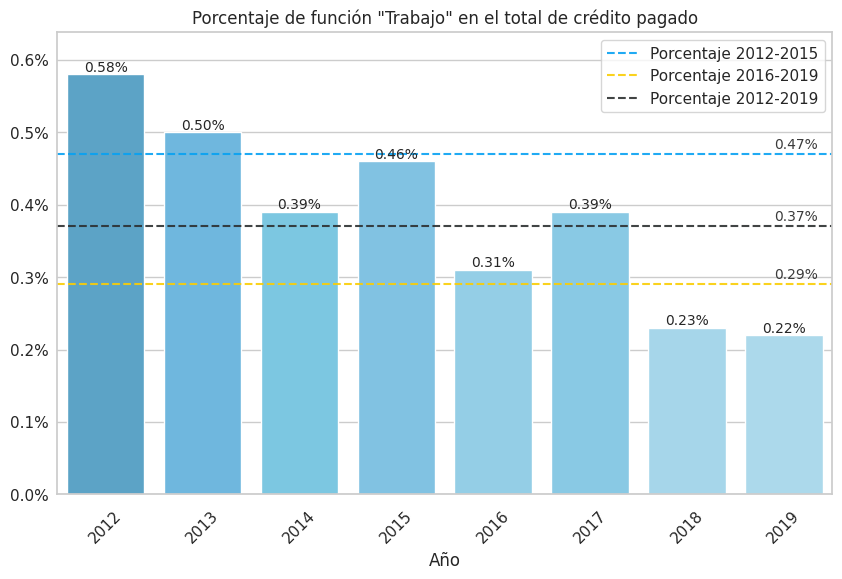

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Datos
años = list(porcentaje_por_año.keys())
porcentajes = list(porcentaje_por_año.values())
periodos = list(porcentaje_por_periodo.keys())
porcentajes_periodos = list(porcentaje_por_periodo.values())

# Configuración de Seaborn
sns.set_theme(style="whitegrid")

# Crear la figura y el eje
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras
palette = ['#4aa9d8', '#5dbdf0', '#6bcff2', '#71c8f2', '#86d4f4', '#7acff3', '#9bdbf5', '#a2ddf5']
ax = sns.barplot(x=años, y=porcentajes, hue=años , legend=False, palette=palette)

# Configuración de etiquetas y título
ax.set_xlabel('Año')
ax.set_title('Porcentaje de función "Trabajo" en el total de crédito pagado')
ax.set_xticks(range(len(años)))
ax.set_ylim(0, max(porcentajes) * 1.1)
ax.set_xticklabels(años, rotation=45)

# Formatear el eje y como porcentaje
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))
ax.yaxis.set_tick_params(pad=0.05)

# Etiquetas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10)

# Líneas punteadas para los períodos
colores = ['#07a1f2', '#facd05', '#2c2f30']
for i in range(len(periodos)):
    plt.axhline(porcentajes_periodos[i], color=colores[i], linestyle='--',
                linewidth=1.5, label=f'Porcentaje {periodos[i]}', alpha=0.9)
    plt.text(len(años) - 1.1, porcentajes_periodos[i] + 0.008, f'{porcentajes_periodos[i]}%', fontsize=10, alpha=0.9)

# Añadir leyenda
plt.legend()

# Guardar y mostrar el gráfico
plt.savefig('plots/presupuesto/pagos_funcion_trabajo.png', bbox_inches='tight')
plt.show()

### Gráfico de pagos con función trabajo por año 